In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, wilcoxon
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score
import glob
from collections import Counter
import os
from matplotlib.lines import Line2D

In [ ]:
df = pd.read_csv('')

In [5]:
def is_slippage_region(row, window_size=20, min_repeat_length=3):
    """
    Determine if an indel is located in a slippage-prone region.
    
    Args:
        row: DataFrame row containing variant information
        window_size (int): Size of sequence window to check for repeats around the indel
        min_repeat_length (int): Minimum repeat length to consider as slippage-prone
        
    Returns:
        dict: Dictionary with slippage information, including:
            - is_slippage_region: Boolean indicating if variant is in a slippage-prone region
            - repeat_type: Type of repeat (homopolymer, dinucleotide, etc.)
            - repeat_unit: The repeated unit
            - repeat_count: Number of repeat units
            - slippage_score: Score indicating slippage propensity
    """
    # Extract variant information
    pos = row['POS']
    ref = row['REF']
    alt = row['ALT']
    wt_seq_start = row['WT_SEQUENCE_START']
    wt_sequence = row['WT_SEQUENCE']
    
    # Calculate variant position within the WT sequence
    variant_pos = pos - wt_seq_start
    
    # Ensure variant position is within sequence bounds
    if variant_pos < 0 or variant_pos >= len(wt_sequence):
        return {
            'is_slippage_region': False,
            'repeat_type': None,
            'repeat_unit': None,
            'repeat_count': 0,
            'slippage_score': 0.0
        }
    
    # Determine if it's an insertion or deletion
    is_insertion = len(alt) > len(ref)
    is_deletion = len(ref) > len(alt)
    
    if not (is_insertion or is_deletion):
        # SNP or complex variant, not an indel
        return {
            'is_slippage_region': False,
            'repeat_type': None,
            'repeat_unit': None, 
            'repeat_count': 0,
            'slippage_score': 0.0
        }
    
    # Extract the region around the variant for analysis
    start_idx = max(0, variant_pos - window_size//2)
    end_idx = min(len(wt_sequence), variant_pos + window_size//2)
    region = wt_sequence[start_idx:end_idx]
    
    # Analyze the sequence for different repeat types
    results = analyze_repeats(region, min_repeat_length)
    
    # Special check for deletions: do they match the repeat unit?
    if is_deletion:
        deleted_bases = ref[1:] if len(alt) == 1 else ref[len(alt):]
        
        for repeat in results['repeats']:
            repeat_unit = repeat['unit']
            
            # Check if deleted sequence consists of or contains complete repeat units
            if deleted_bases == repeat_unit or deleted_bases.startswith(repeat_unit) or deleted_bases.endswith(repeat_unit):
                repeat['matches_deleted'] = True
                results['is_slippage_region'] = True
            # Check if deletion is within a repeat region
            elif repeat['start'] <= (variant_pos - start_idx) <= repeat['end']:
                results['is_slippage_region'] = True
    
    # Special check for insertions: do they match the repeat unit?
    if is_insertion:
        inserted_bases = alt[1:] if len(ref) == 1 else alt[len(ref):]
        
        for repeat in results['repeats']:
            repeat_unit = repeat['unit']
            
            # Check if inserted sequence consists of or contains complete repeat units
            if inserted_bases == repeat_unit or inserted_bases.startswith(repeat_unit) or inserted_bases.endswith(repeat_unit):
                repeat['matches_inserted'] = True
                results['is_slippage_region'] = True
            # Check if insertion is within a repeat region
            elif repeat['start'] <= (variant_pos - start_idx) <= repeat['end']:
                results['is_slippage_region'] = True
    
    # Prepare the return value
    if results['repeats']:
        top_repeat = max(results['repeats'], key=lambda x: x['count'] * len(x['unit']))
        return {
            'is_slippage_region': results['is_slippage_region'],
            'repeat_type': top_repeat['type'],
            'repeat_unit': top_repeat['unit'],
            'repeat_count': top_repeat['count'],
            'slippage_score': results['slippage_score']
        }
    else:
        return {
            'is_slippage_region': False,
            'repeat_type': None,
            'repeat_unit': None,
            'repeat_count': 0,
            'slippage_score': results['slippage_score']
        }

def analyze_repeats(sequence, min_repeat_length=3):
    """
    Analyze a DNA sequence for repeats that could cause slippage.
    
    Args:
        sequence (str): DNA sequence to analyze
        min_repeat_length (int): Minimum number of repeat units to consider
        
    Returns:
        dict: Information about repeats in the sequence
    """
    sequence = sequence.upper()
    results = {
        'is_slippage_region': False,
        'slippage_score': 0.0,
        'repeats': []
    }
    
    # 1. Check for homopolymer runs (single base repeats)
    i = 0
    while i < len(sequence):
        j = i
        current_base = sequence[i]
        
        # Find length of homopolymer run
        while j < len(sequence) and sequence[j] == current_base:
            j += 1
        
        run_length = j - i
        if run_length >= min_repeat_length:
            results['repeats'].append({
                'type': 'homopolymer',
                'unit': current_base,
                'count': run_length,
                'start': i,
                'end': j - 1
            })
            results['is_slippage_region'] = True
            results['slippage_score'] += run_length ** 2
        
        i = j
    
    # 2. Check for di/tri/tetra-nucleotide repeats
    for unit_size in range(2, 5):  # Check for 2, 3, and 4-nucleotide repeats
        for i in range(len(sequence) - unit_size):
            repeat_unit = sequence[i:i+unit_size]
            count = 1
            j = i + unit_size
            
            # Count consecutive occurrences of the repeat unit
            while j <= len(sequence) - unit_size and sequence[j:j+unit_size] == repeat_unit:
                count += 1
                j += unit_size
            
            if count >= min_repeat_length:
                repeat_type = {
                    2: 'dinucleotide',
                    3: 'trinucleotide',
                    4: 'tetranucleotide'
                }[unit_size]
                
                results['repeats'].append({
                    'type': repeat_type,
                    'unit': repeat_unit,
                    'count': count,
                    'start': i,
                    'end': j - 1
                })
                results['is_slippage_region'] = True
                
                # Weight larger repeats slightly less than homopolymers or shorter repeats
                weight_factor = {
                    2: 0.8,
                    3: 0.6,
                    4: 0.5
                }[unit_size]
                
                results['slippage_score'] += (count * unit_size) ** 1.5 * weight_factor
                
                # Skip ahead to avoid redundant repeat detection
                i = j - 1
    
    return results


merged_df['slippage_score']= merged_df.apply(lambda x: is_slippage_region(x)['slippage_score'], axis=1)




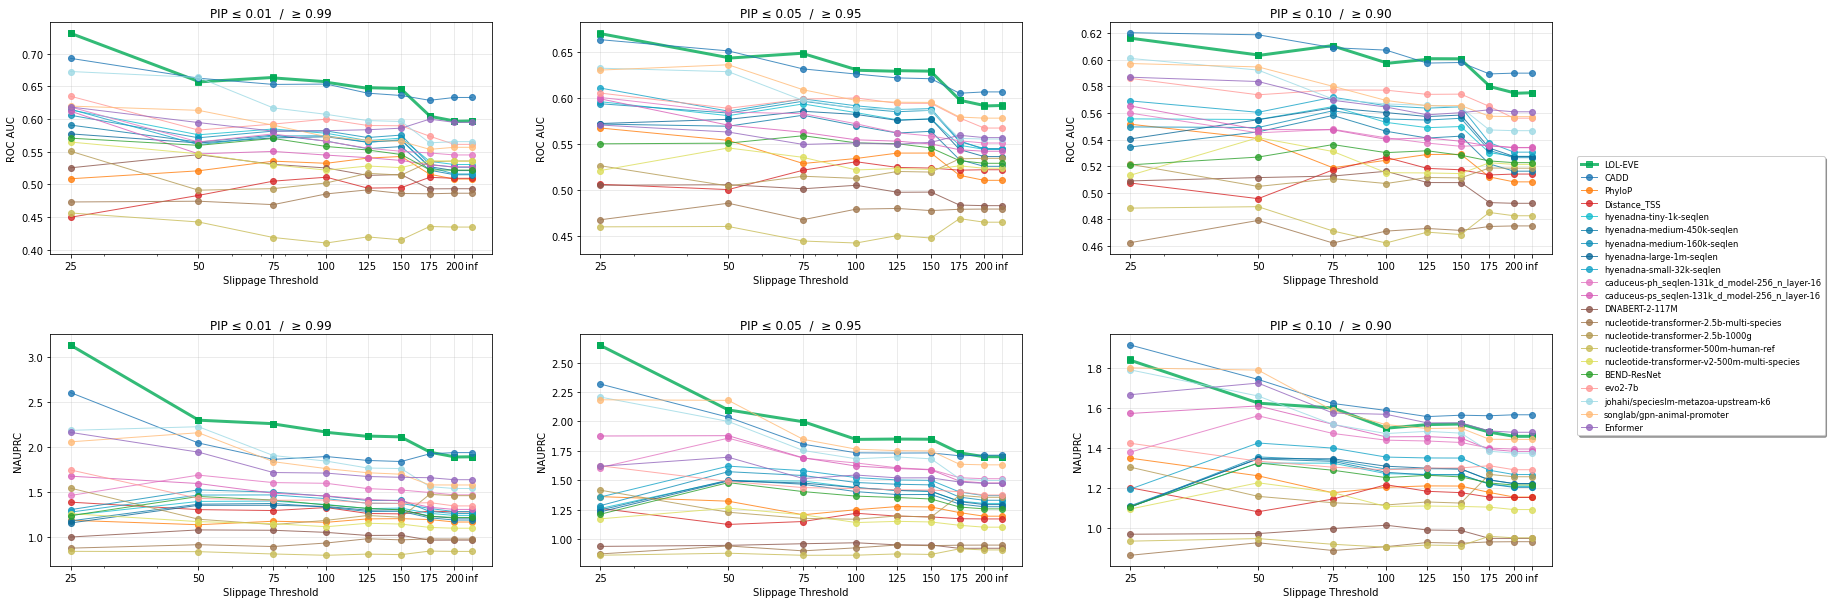


Color assignments:
BEND-ResNet: #2ca02c
CADD: #1f77b4
DNABERT-2-117M: #8c564b
Distance_TSS: #d62728
Enformer: #9467bd
LOL-EVE: #00aa55
PhyloP: #ff7f0e
caduceus-ph_seqlen-131k_d_model-256_n_layer-16: #e377c2
caduceus-ps_seqlen-131k_d_model-256_n_layer-16: #d85fb8
evo2-7b: #ff9896
hyenadna-large-1m-seqlen: #0b6999
hyenadna-medium-160k-seqlen: #1190b8
hyenadna-medium-450k-seqlen: #0e7ca8
hyenadna-small-32k-seqlen: #14a3c7
hyenadna-tiny-1k-seqlen: #17becf
johahi/specieslm-metazoa-upstream-k6: #9edae5
nucleotide-transformer-2.5b-1000g: #b49a53
nucleotide-transformer-2.5b-multi-species: #a0784f
nucleotide-transformer-500m-human-ref: #c8bc57
nucleotide-transformer-v2-500m-multi-species: #dcde5b
songlab/gpn-animal-promoter: #ffbb78


In [8]:

# 1) Prepare your temp dataframe
temp = merged_df.copy()
temp = temp[temp.slippage_score < 200]
OUTDIR='/n/groups/marks/users/courtney/projects/regulatory_genomics/models/LOL-EVE/src/benchmarks/causal_eqtls'

# 2) Models list (only those present in temp)
models = [
    'ar_forward_llr_no_ablation_primate',
    'ar_forward_llr_no_ablation_mammal',
    'CADD','PhyloP','Distance_TSS',
    'mean_cross_entropy_diff_hyenadna-tiny-1k-seqlen',
    'mean_cross_entropy_diff_hyenadna-medium-450k-seqlen',
    'mean_cross_entropy_diff_hyenadna-medium-160k-seqlen',
    'mean_cross_entropy_diff_hyenadna-large-1m-seqlen',
    'mean_cross_entropy_diff_hyenadna-small-32k-seqlen',
    'mean_cross_entropy_diff_caduceus-ph_seqlen-131k_d_model-256_n_layer-16',
    'mean_cross_entropy_diff_caduceus-ps_seqlen-131k_d_model-256_n_layer-16',
    'mean_cross_entropy_diff_DNABERT-2-117M',
    'mean_cross_entropy_diff_nucleotide-transformer-2.5b-multi-species',
    'mean_cross_entropy_diff_nucleotide-transformer-2.5b-1000g',
    'mean_cross_entropy_diff_nucleotide-transformer-500m-human-ref',
    'mean_cross_entropy_diff_nucleotide-transformer-v2-500m-multi-species',
    'mean_cross_entropy_diff_BEND-ResNet',
    'mean_cross_entropy_diff_evo2-7b',
    'mean_cross_entropy_diff_johahi/specieslm-metazoa-upstream-k6',
    'mean_cross_entropy_diff_songlab/gpn-animal-promoter',
    'Enformer'
]
existing_models = [m for m in models if m in temp.columns]

# 3) Define thresholds
pip_thresholds      = [0.01, 0.05, 0.10]       # causal ≥ .99, .95, .90
slippage_thresholds = [25, 50, 75, 100, 125, 150,175,200, float('inf')]

# 4) Loop & compute metrics, dropping NaNs
records = []
for pip in pip_thresholds:
    df = temp.copy()
    df['pip_group'] = df['pip'].apply(
        lambda x: 'causal'    if x >= 1 - pip
                  else 'background' if x <= pip
                  else 'drop'
    )
    df = df[df.pip_group != 'drop']
    df['binary_label'] = (df.pip_group == 'causal').astype(int)
    
    for slip in slippage_thresholds:
        sub = df[df.slippage_score <= slip]
        if len(sub) < 20 or sub.pip_group.nunique() < 2:
            continue
        
        y_full = sub['binary_label']
        for m in existing_models:
            scores_full = sub[m].abs()
            
            # drop NaNs
            valid = scores_full.notna()
            y = y_full[valid]
            scores = scores_full[valid]
            
            # require enough points and both classes present
            if len(scores) < 10 or y.nunique() < 2:
                continue
            
            roc    = roc_auc_score(y, scores)
            p, r, _ = precision_recall_curve(y, scores)
            auprc  = auc(r, p)
            base   = y.mean()
            nauprc = auprc / base if base > 0 else np.nan
            
            records.append({
                'Model'   : m,
                'PIP'     : pip,
                'Slippage': slip,
                'ROC AUC' : roc,
                'NAUPRC'  : nauprc
            })

results_df = pd.DataFrame(records)

# 5) Prep slippage for plotting (inf → 1.1×max)
results_df['Slippage_plot'] = results_df['Slippage'].replace({np.inf: np.nan})
max_sl = results_df['Slippage_plot'].max()
results_df['Slippage_plot'].fillna(max_sl * 1.1, inplace=True)

# 6) Map to short "Type" for legend
def short_type(name):
    return 'LOL-EVE' if 'ar_forward_llr' in name else name.split('mean_cross_entropy_diff_')[-1]

results_df['Type'] = results_df['Model'].map(short_type)
types = results_df['Type'].unique()

# 7) Custom color map for each model type
model_color_map = {
    'LOL-EVE': '#00aa55',  # Your specified green
    'CADD': '#1f77b4',     # Blue
    'PhyloP': '#ff7f0e',   # Orange
    'Distance_TSS': '#d62728',  # Red
    'Enformer': '#9467bd',  # Purple
    
    # HyenaDNA models - shades of teal/cyan
    'hyenadna-tiny-1k-seqlen': '#17becf',
    'hyenadna-small-32k-seqlen': '#14a3c7',
    'hyenadna-medium-160k-seqlen': '#1190b8',
    'hyenadna-medium-450k-seqlen': '#0e7ca8',
    'hyenadna-large-1m-seqlen': '#0b6999',
    
    # Caduceus models - shades of pink/magenta
    'caduceus-ph_seqlen-131k_d_model-256_n_layer-16': '#e377c2',
    'caduceus-ps_seqlen-131k_d_model-256_n_layer-16': '#d85fb8',
    
    # DNABERT and Nucleotide Transformers - shades of brown/tan
    'DNABERT-2-117M': '#8c564b',
    'nucleotide-transformer-2.5b-multi-species': '#a0784f',
    'nucleotide-transformer-2.5b-1000g': '#b49a53',
    'nucleotide-transformer-500m-human-ref': '#c8bc57',
    'nucleotide-transformer-v2-500m-multi-species': '#dcde5b',
    
    # Other specialized models - distinct colors
    'BEND-ResNet': '#2ca02c',  # Green (different from LOL-EVE)
    'evo2-7b': '#ff9896',      # Light red/pink
    'johahi/specieslm-metazoa-upstream-k6': '#9edae5',  # Light blue
    'songlab/gpn-animal-promoter': '#ffbb78',  # Light orange
}

# Apply colors and markers
model_colors = {t: model_color_map.get(t, '#7f7f7f') for t in types}  # Default gray if not found
model_markers = {t: ('s' if t == 'LOL-EVE' else 'o') for t in types}

# 8) Plot grid with proper legend space allocation
fig, axes = plt.subplots(2, 3, figsize=(30, 10))  # Increased width to accommodate legend
fig.subplots_adjust(right=.82,hspace=0.35)  # Leave space for legend on the right

metrics = ['ROC AUC', 'NAUPRC']

for i, metric in enumerate(metrics):
    for j, pip in enumerate(pip_thresholds):
        ax = axes[i, j]
        dfp = results_df[results_df['PIP'] == pip]
        
        for t in types:
            sub = dfp[dfp['Type'] == t].sort_values('Slippage_plot')
            if sub.empty:
                continue
            lw = 3 if t == 'LOL-EVE' else 1
            ax.plot(
                sub['Slippage_plot'], sub[metric],
                label     = t,
                color     = model_colors[t],
                marker    = model_markers[t],
                linewidth = lw,
                alpha     = 0.8
            )
        
        ax.set_xscale('log')
        ax.set_xticks([25, 50, 75, 100, 125, 150,175,200,  max_sl * 1.1])
        ax.set_xticklabels([25, 50, 75, 100, 125, 150,175,200, float('inf')])
        ax.set_xlabel('Slippage Threshold')
        ax.set_ylabel(metric)
        ax.set_title(f'PIP ≤ {pip:.2f}  /  ≥ {1-pip:.2f}')
        ax.grid(True, alpha=0.3)

# 9) Shared legend to the right with proper positioning
handles, labels = axes[0, 0].get_legend_handles_labels()

# Get unique handles/labels (in case of duplicates)
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Create legend positioned to the right of the entire figure
legend = fig.legend(unique_handles, unique_labels,
                   loc='center left',
                   bbox_to_anchor=(0.83, 0.5),
                   fontsize='small',
                   frameon=True,
                   fancybox=True,
                   shadow=True)



# Save with bbox_inches='tight' to ensure legend is included
plt.savefig(os.path.join(OUTDIR, 'eqtls_appendix.pdf'),dpi=300)
plt.show()

# Optional: Print color assignments for reference
print("\nColor assignments:")
for model_type in sorted(types):
    print(f"{model_type}: {model_colors[model_type]}")

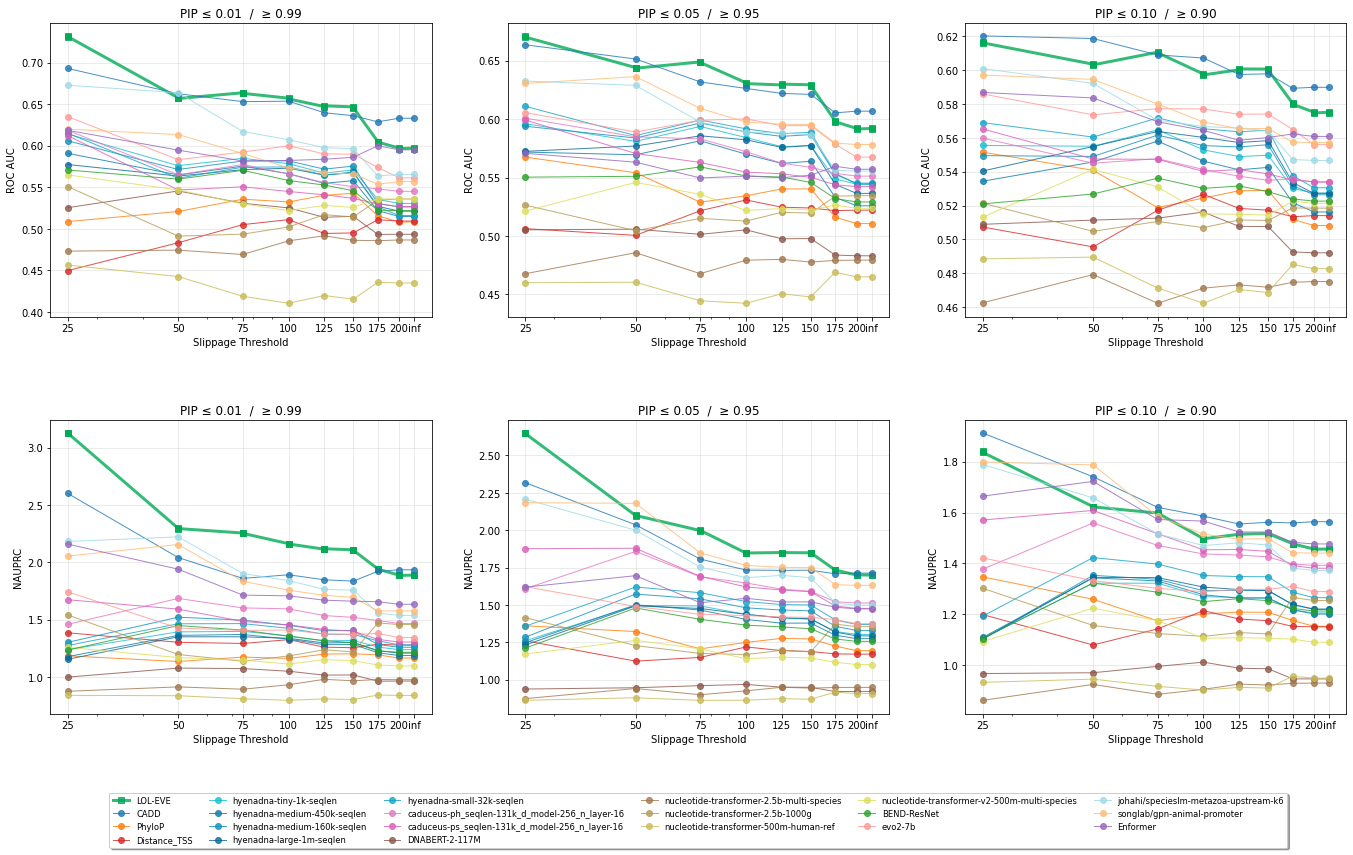

In [10]:
# 8) Plot grid with proper legend space allocation
#    – make the figure wider/taller
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
#    – leave room at the bottom instead of the right
fig.subplots_adjust(left=0.05, right=0.95, top=0.95,
                    bottom=0.15,  # give space for the legend below
                    hspace=0.35)

metrics = ['ROC AUC', 'NAUPRC']

for i, metric in enumerate(metrics):
    for j, pip in enumerate(pip_thresholds):
        ax = axes[i, j]
        dfp = results_df[results_df['PIP'] == pip]
        
        for t in types:
            sub = dfp[dfp['Type'] == t].sort_values('Slippage_plot')
            if sub.empty: continue
            lw = 3 if t == 'LOL-EVE' else 1
            ax.plot(
                sub['Slippage_plot'], sub[metric],
                label     = t,
                color     = model_colors[t],
                marker    = model_markers[t],
                linewidth = lw,
                alpha     = 0.8
            )
        
        ax.set_xscale('log')
        ax.set_xticks([25, 50, 75, 100, 125, 150, 175, 200, max_sl * 1.1])
        ax.set_xticklabels([25, 50, 75, 100, 125, 150, 175, 200, float('inf')])
        ax.set_xlabel('Slippage Threshold')
        ax.set_ylabel(metric)
        ax.set_title(f'PIP ≤ {pip:.2f}  /  ≥ {1-pip:.2f}')
        ax.grid(True, alpha=0.3)

# 9) Shared legend below the plots
handles, labels = axes[0, 0].get_legend_handles_labels()
# dedupe labels
unique = dict(zip(labels, handles))
legend = fig.legend(
    unique.values(),
    unique.keys(),
    loc='lower center',
    bbox_to_anchor=(0.5, -0.01),
    ncol=6,              # spread legend entries across 6 columns
    fontsize='small',
    frameon=True,
    fancybox=True,
    shadow=True
)

# Save and show
plt.savefig(f'{OUTDIR}/eqtls_appendix_big_legend_bottom.pdf',dpi=300, bbox_inches='tight')
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

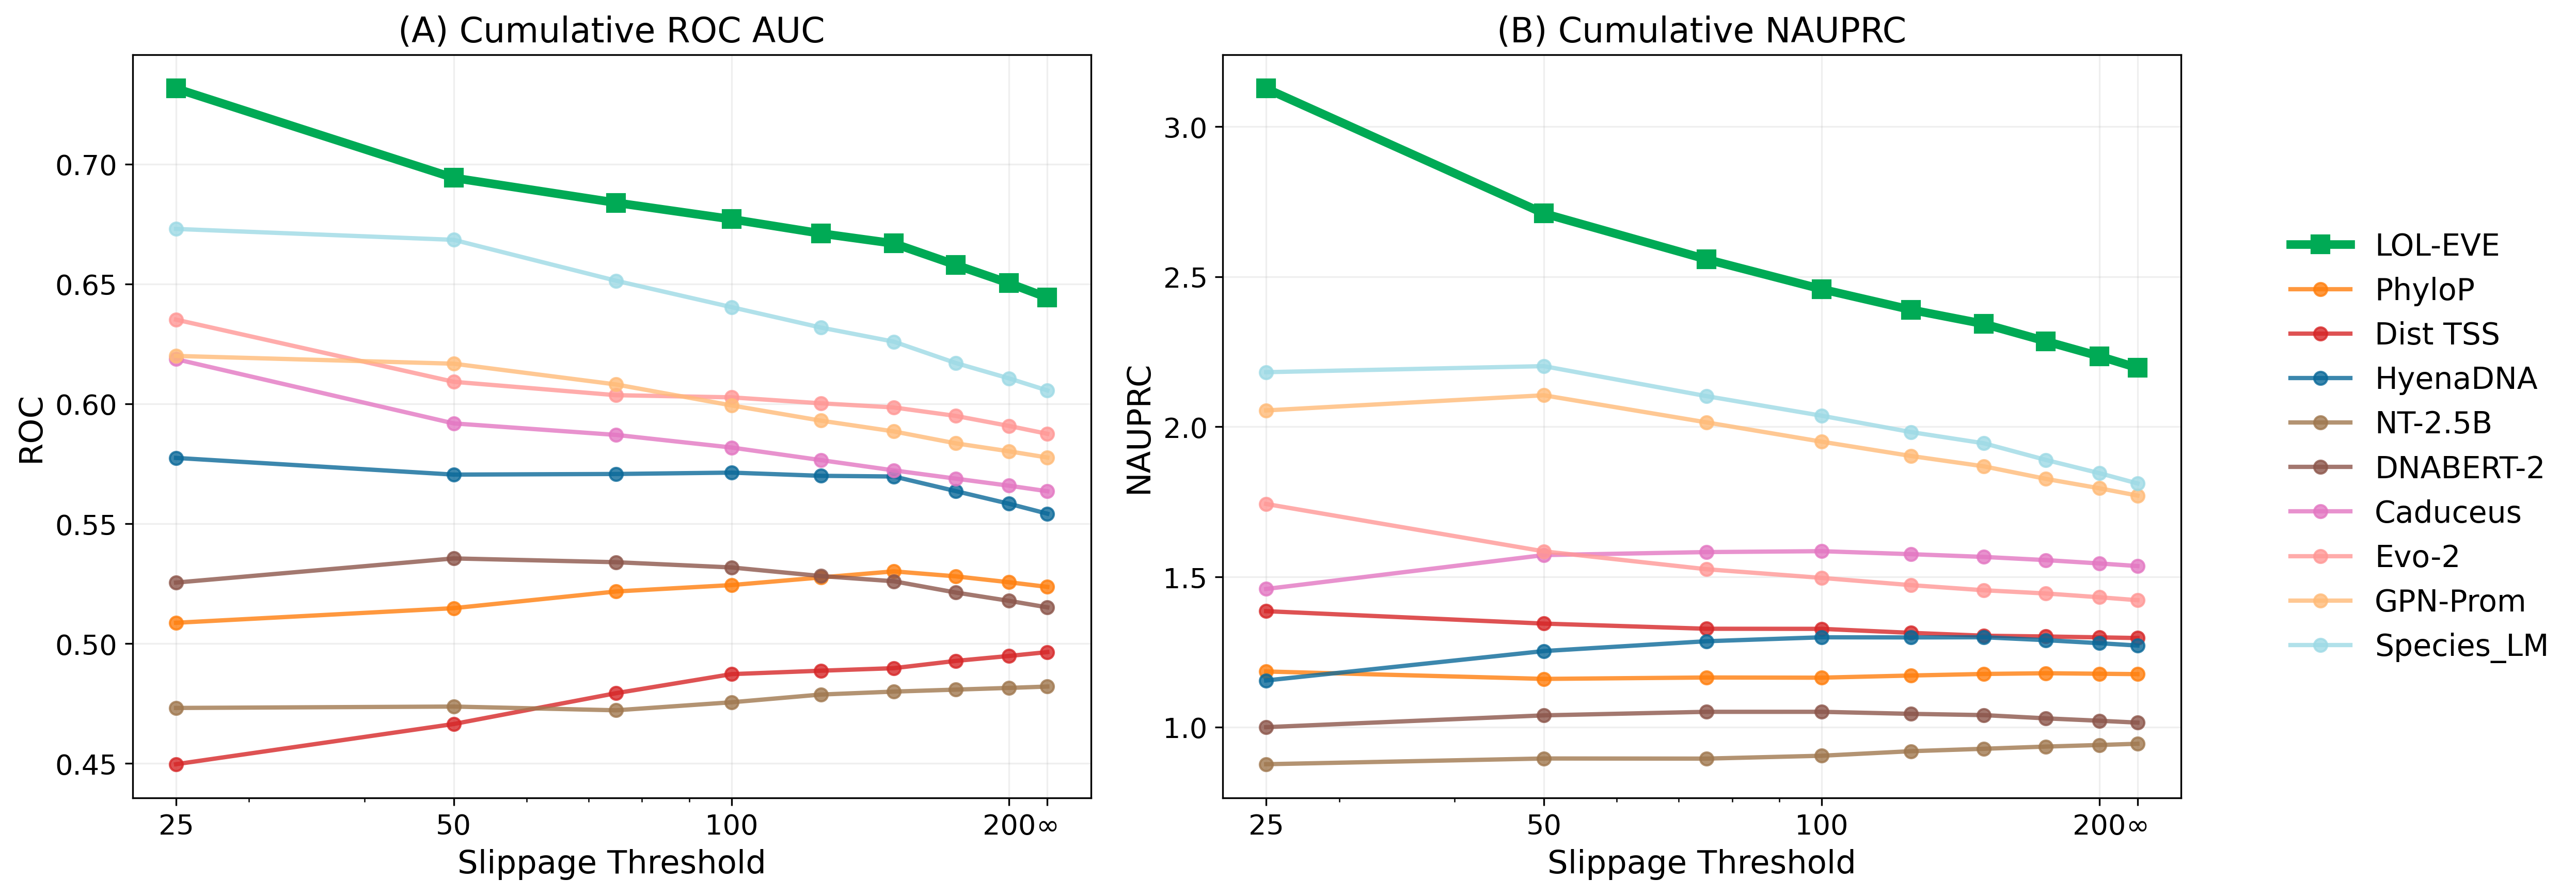

In [11]:
# ─── A) pick one representative per arch with its display name ─────────────

# Updated model_colors to match the short_type mapping from original code
model_colors = {
    'LOL-EVE': '#00aa55',
    'CADD': '#1f77b4',
    'PhyloP': '#ff7f0e',
    'Distance_TSS': '#d62728',
    'hyenadna-tiny-1k-seqlen': '#17becf',
    'hyenadna-medium-450k-seqlen': '#0e7ca8',
    'hyenadna-medium-160k-seqlen': '#1190b8',
    'hyenadna-large-1m-seqlen': '#0b6999',
    'hyenadna-small-32k-seqlen': '#14a3c7',
    'caduceus-ph_seqlen-131k_d_model-256_n_layer-16': '#e377c2',
    'caduceus-ps_seqlen-131k_d_model-256_n_layer-16': '#d85fb8',
    'DNABERT-2-117M': '#8c564b',
    'nucleotide-transformer-2.5b-multi-species': '#a0784f',
    'nucleotide-transformer-2.5b-1000g': '#b49a53',
    'nucleotide-transformer-500m-human-ref': '#c8bc57',
    'nucleotide-transformer-v2-500m-multi-species': '#dcde5b',
    'BEND-ResNet': '#2ca02c',
    'evo2-7b': '#ff9896',
    'johahi/specieslm-metazoa-upstream-k6': '#9edae5',
    'songlab/gpn-animal-promoter': '#ffbb78',
    'Enformer': '#9467bd'
}

rep_models = {
    'LOL-EVE'    : 'ar_forward_llr_no_ablation_mammal',
#    'CADD'       : 'CADD',
    'PhyloP'     : 'PhyloP',
    'Dist TSS'   : 'Distance_TSS',
    'HyenaDNA'   : 'mean_cross_entropy_diff_hyenadna-large-1m-seqlen',
    'NT-2.5B'    : 'mean_cross_entropy_diff_nucleotide-transformer-2.5b-multi-species',
    'DNABERT-2'  : 'mean_cross_entropy_diff_DNABERT-2-117M',
    'Caduceus'   : 'mean_cross_entropy_diff_caduceus-ph_seqlen-131k_d_model-256_n_layer-16',
    'Evo-2'      : 'mean_cross_entropy_diff_evo2-7b',
    'GPN-Prom'  : 'mean_cross_entropy_diff_songlab/gpn-animal-promoter',
    'Species_LM' :  'mean_cross_entropy_diff_johahi/specieslm-metazoa-upstream-k6'
#    'Enformer'   : 'Enformer'
}

# Function to get the short type name (matching your original code)
def short_type(name):
    return 'LOL-EVE' if 'ar_forward_llr' in name else name.split('mean_cross_entropy_diff_')[-1]

# Filter out all other models:
mask = results_df['Model'].isin(rep_models.values())
filtered_df = results_df[mask].copy()

# ─── B) cumulative plot data (for PIP=0.01) ────────────────────────────────
df01 = filtered_df[filtered_df['PIP'] == 0.01]
slips = sorted(df01['Slippage_plot'].unique())

cum = []
for disp, full_model_name in rep_models.items():
    sub = df01[df01['Model'] == full_model_name].sort_values('Slippage_plot')
    if sub.empty: 
        continue
    
    # Handle missing slippage values by forward filling
    sub = sub.set_index('Slippage_plot').reindex(slips).ffill()
    
    # Calculate cumulative means
    cumroc = sub['ROC AUC'].expanding().mean()
    cumnauprc = sub['NAUPRC'].expanding().mean()
    
    for s, r, n in zip(slips, cumroc, cumnauprc):
        if not (pd.isna(r) or pd.isna(n)):  # Skip NaN values
            cum.append({'Display': disp, 'Slippage': s, 'ROC': r, 'NAUPRC': n})

cum_df = pd.DataFrame(cum)

# ─── C) style & figure setup ────────────────────────────────────────────────
plt.rcParams.update({
    'font.family': 'sans-serif', 
    'font.sans-serif': ['Arial'],
    'font.size': 14, 
    'axes.titlesize': 16, 
    'axes.labelsize': 15,
    'xtick.labelsize': 13, 
    'ytick.labelsize': 13, 
    'grid.alpha': 0.2,
    'figure.dpi': 300
})

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

metrics = [('ROC', '(A) Cumulative ROC AUC'),
           ('NAUPRC', '(B) Cumulative NAUPRC')]

# Pre-compute 5 log-ticks: 25, 50, 100, 200, ∞
max_slip = max(slips) if slips else 220
xticks = [25, 50, 100, 200, max_slip]
xtlabels = ['25', '50', '100', '200', '∞']

for ax, (col, title) in zip(axes, metrics):
    for disp, full_model_name in rep_models.items():
        sub = cum_df[cum_df['Display'] == disp]
        if sub.empty:
            continue
            
        # Get the short type name for color lookup
        short_name = short_type(full_model_name)
        is_lol_eve = (short_name == 'LOL-EVE')
        
        ax.plot(
            sub['Slippage'], sub[col],
            label=disp,
            color=model_colors[short_name],
            linewidth=4 if is_lol_eve else 2,
            marker='s' if is_lol_eve else 'o',
            markersize=8 if is_lol_eve else 6,
            alpha=1.0 if is_lol_eve else 0.8,
        )
    
    ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtlabels)
    ax.set_xlabel('Slippage Threshold')
    ax.set_ylabel(col)
    ax.set_title(title)
    ax.grid(True)

# ─── D) deduplicated, custom-color legend ─────────────────────────────────
# Build handles in rep_models order:
handles = []
for disp, full_model_name in rep_models.items():
    # Skip if no data for this model
    if cum_df[cum_df['Display'] == disp].empty:
        continue
        
    short_name = short_type(full_model_name)
    is_lol_eve = (short_name == 'LOL-EVE')
    
    handles.append(Line2D([0], [0],
        color=model_colors[short_name],
        lw=4 if is_lol_eve else 2,
        marker='s' if is_lol_eve else 'o',
        markersize=8 if is_lol_eve else 6,
        alpha=1.0 if is_lol_eve else 0.8,
        label=disp
    ))

fig.tight_layout(rect=[0, 0, 0.8, 1])
fig.legend(
    handles, [h.get_label() for h in handles],
    loc='center right', bbox_to_anchor=(0.93, 0.5),
    frameon=False, ncol=1
)

plt.savefig(os.path.join(OUTDIR, 'main_fig.pdf'), bbox_inches='tight')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

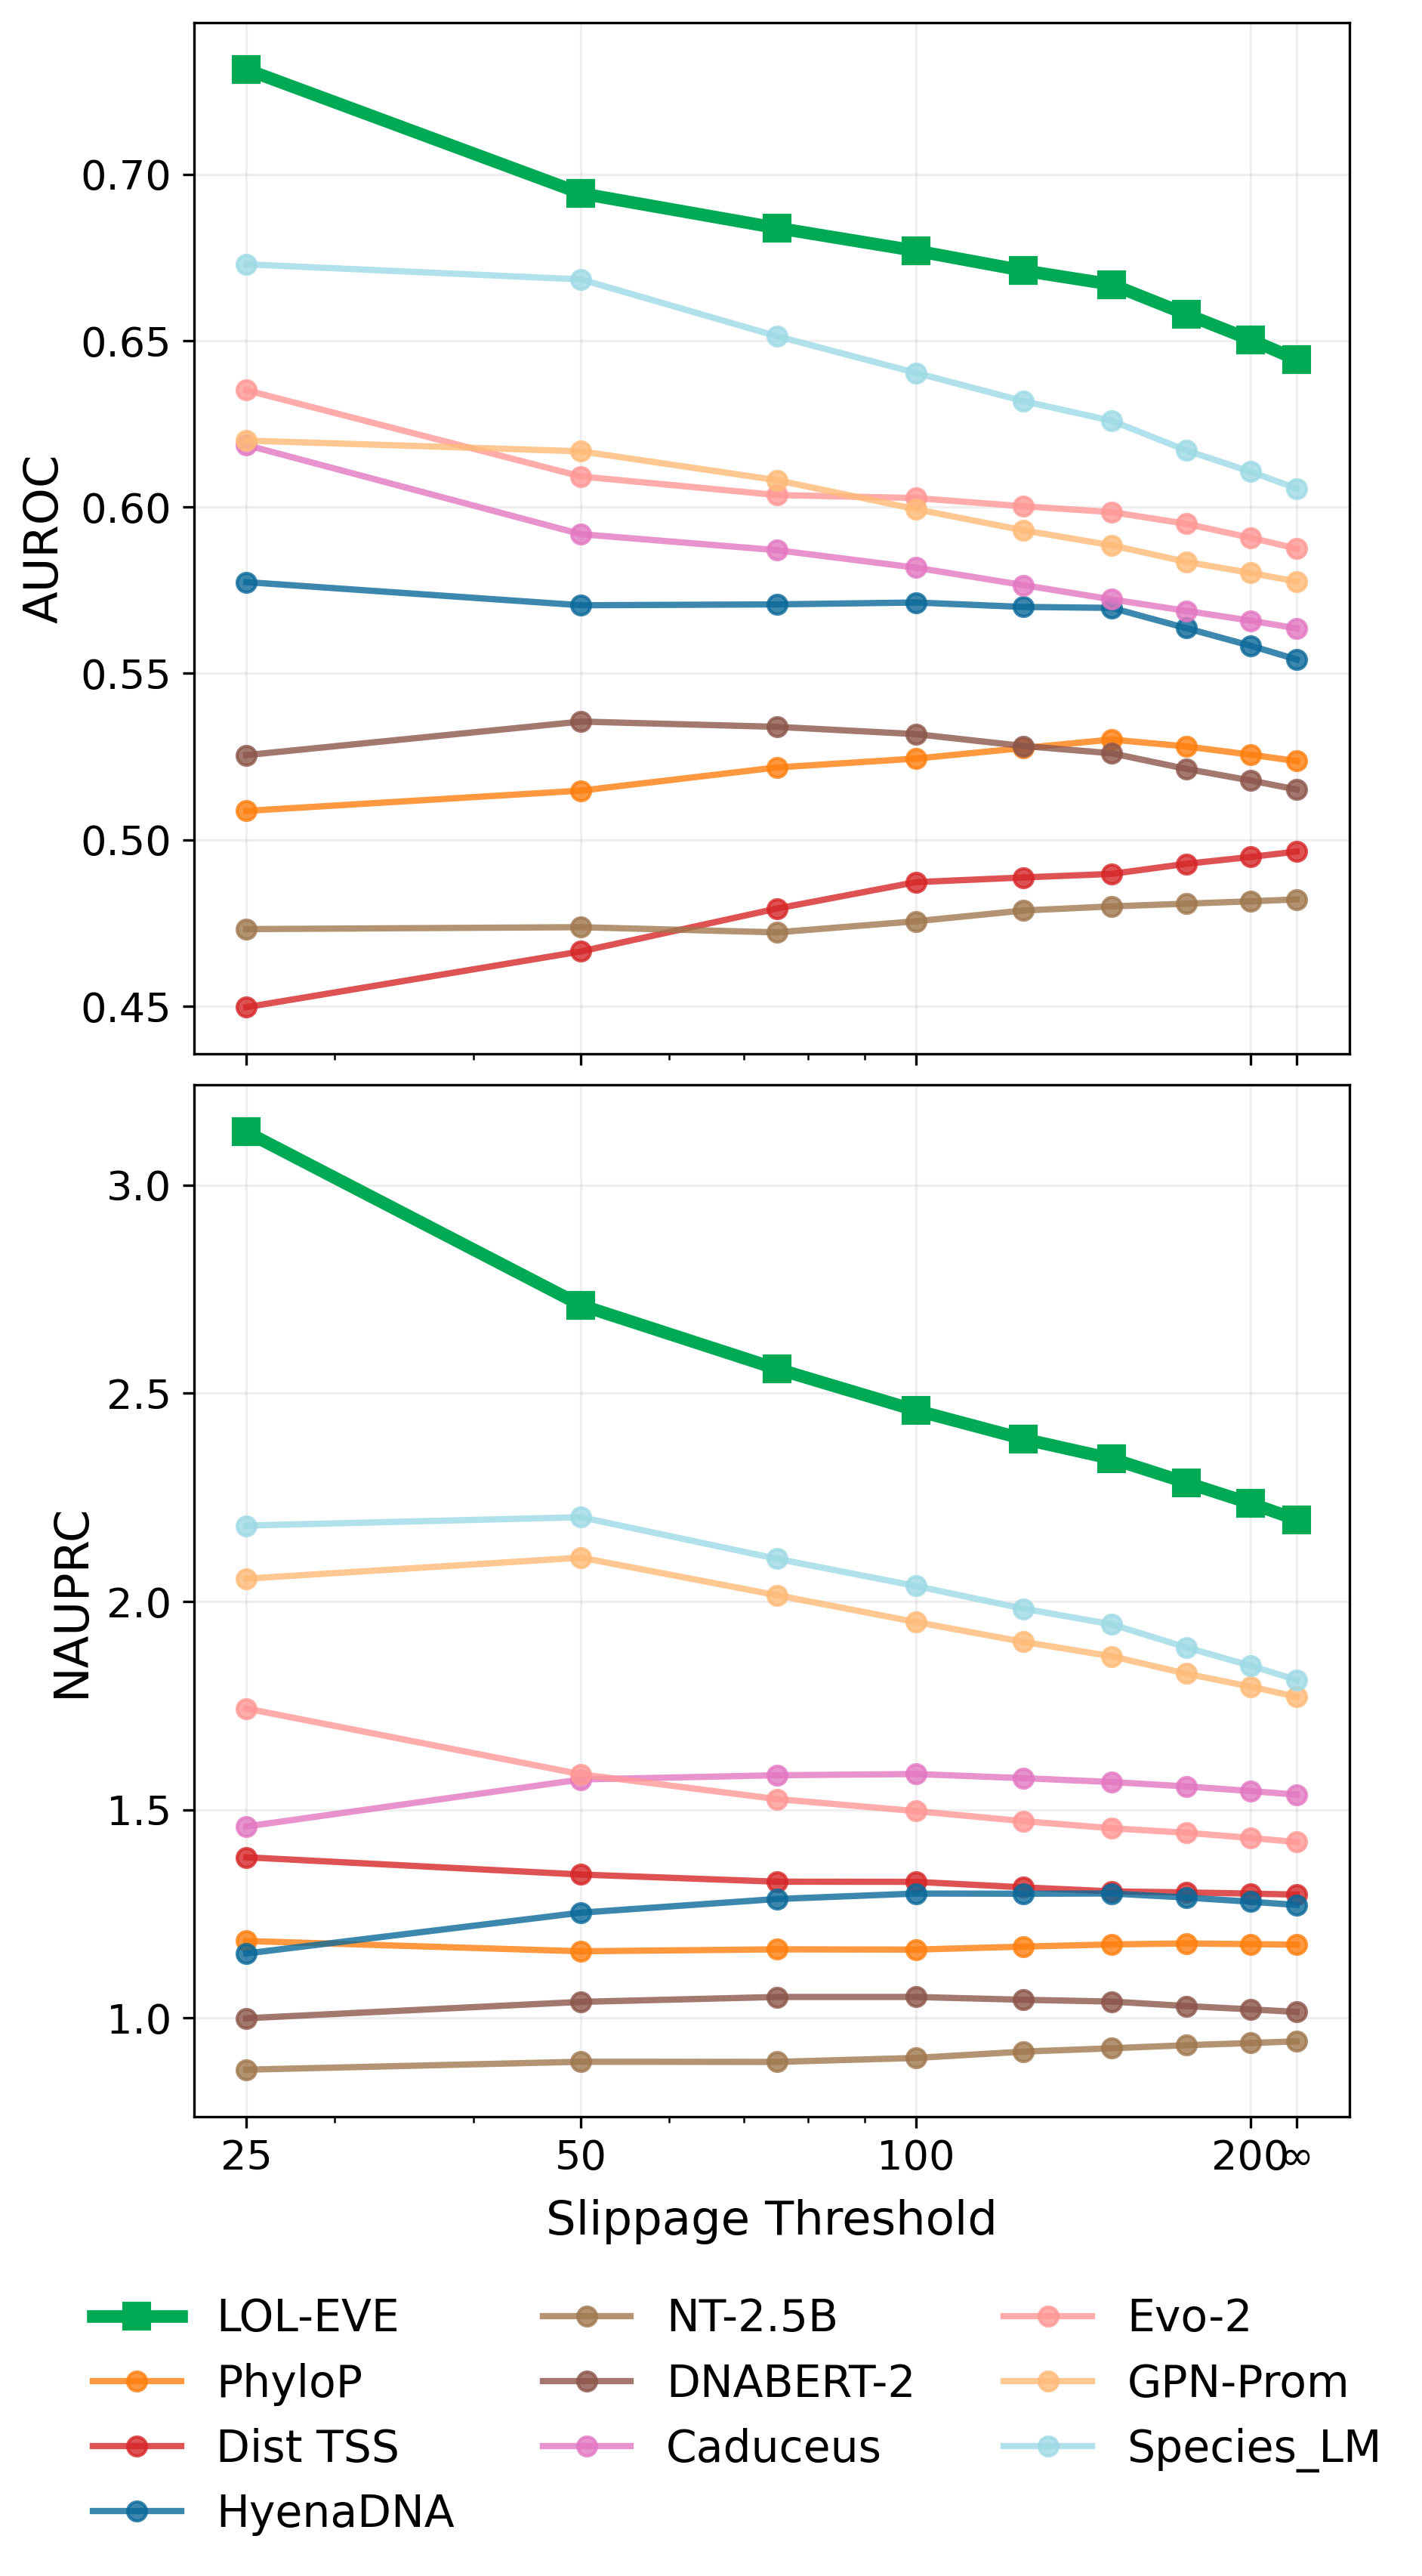

In [13]:

# … [your model_colors, rep_models, data processing, cum_df setup] …
cum_df.rename({'ROC':'AUROC'}, axis=1, inplace=True)
# ─── C) style & figure setup ────────────────────────────────────────────────
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'grid.alpha': 0.2,
    'figure.dpi': 300
})

# 2 rows, 1 column, share x
fig, axes = plt.subplots(2, 1, figsize=(6, 12), sharex=True)

metrics = [
    ('AUROC', '(A) Cumulative ROC AUC'),
    ('NAUPRC', '(B) Cumulative NAUPRC')
]

# Precompute log‐ticks
slips    = sorted(cum_df['Slippage'].unique())
max_slip = max(slips) if slips else 220
xticks   = [25, 50, 100, 200, max_slip]
xtlabels = ['25', '50', '100', '200', '∞']

for ax, (col, _) in zip(axes, metrics):
    for disp, full_model_name in rep_models.items():
        sub = cum_df[cum_df['Display'] == disp]
        if sub.empty:
            continue
        short_name = short_type(full_model_name)
        is_lol_eve = (short_name == 'LOL-EVE')
        ax.plot(
            sub['Slippage'], sub[col],
            label=disp,
            color=model_colors[short_name],
            linewidth=4 if is_lol_eve else 2,
            marker='s' if is_lol_eve else 'o',
            markersize=8 if is_lol_eve else 6,
            alpha=1.0 if is_lol_eve else 0.8,
        )
    ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtlabels)
    ax.set_ylabel(col)
    ax.grid(True)
    ax.label_outer()

# Add xlabel only to bottom subplot
axes[-1].set_xlabel('Slippage Threshold')

# build a single legend at the bottom
handles = [
    Line2D([0], [0],
           color=model_colors[short_type(rep_models[d])],
           lw=4 if d=='LOL-EVE' else 2,
           marker='s' if d=='LOL-EVE' else 'o',
           markersize=8 if d=='LOL-EVE' else 6,
           alpha=1.0 if d=='LOL-EVE' else 0.8,
           label=d)
    for d in rep_models
    if not cum_df[cum_df['Display']==d].empty
]

# push axes up, reduce hspace for tight stack
fig.subplots_adjust(
    left=0.1,
    right=0.95,
    top=0.95,
    bottom=0.18,    # ← move axes block down less
    hspace=0.03     # ← almost zero vertical gap
)

# Raise the x‐axis label a bit so it’s above the legend
axes[-1].xaxis.set_label_coords(0.5, -0.08)

# Drop the legend just below that
fig.legend(
    handles, [h.get_label() for h in handles],
    loc='upper center',
    bbox_to_anchor=(0.5, 0.12),  # ← nudge up/down as needed
    frameon=False,
    ncol=3,
    borderaxespad=0
)


# save
plt.savefig(
    f'{OUTDIR}/main_fig_vertical.pdf',
    bbox_inches='tight'
)
plt.show()


In [ ]:

# 1) thresholds to iterate
pip_thresholds      = [0.001, 0.01, 0.05]       # causal ≥ .99, .95, .90
slippage_thresholds = [10, 20, 30, 40, 50, 75, 100, 200, 300, 400, 500, float('inf')]

# 2) choose your input DataFrame
df = merged_df.copy()   # or temp, if you’ve already filtered on slippage etc.

# 3) find a gene column if one exists
gene_col = next((c for c in df.columns if 'gene' in c.lower()), None)

# 4) collect counts
records = []
for pip in pip_thresholds:
    for slip in slippage_thresholds:
        sub = df[df['slippage_score'] <= slip].copy()
        
        # classify by this pip cutoff
        sub['pip_group'] = sub['pip'].apply(
            lambda x: 'causal'    if x >= 1 - pip
                      else 'background' if x <= pip
                      else 'drop'
        )
        sub = sub[sub['pip_group'] != 'drop']
        
        # counts
        causal_vars     = (sub['pip_group'] == 'causal').sum()
        background_vars = (sub['pip_group'] == 'background').sum()
        
        if gene_col:
            causal_genes     = sub.loc[sub['pip_group']=='causal', gene_col].nunique()
            background_genes = sub.loc[sub['pip_group']=='background', gene_col].nunique()
        else:
            causal_genes = background_genes = np.nan
        
        records.append({
            'PIP Threshold'        : pip,
            'Slippage Threshold'   : slip,
            'Causal Variants'      : int(causal_vars),
            'Background Variants'  : int(background_vars),
            'Causal Genes'         : int(causal_genes) if not np.isnan(causal_genes) else np.nan,
            'Background Genes'     : int(background_genes) if not np.isnan(background_genes) else np.nan
        })

# 5) assemble into a DataFrame
counts_df = pd.DataFrame(records)

# Method 2: Set display options globally
pd.set_option('display.max_columns', None)


# Optional: pivot so pip thresholds are rows and slippage are columns
pivot_variants = counts_df.pivot_table(
    index='PIP Threshold',
    columns='Slippage Threshold',
    values=['Causal Variants','Background Variants']
)

pivot_genes = counts_df.pivot_table(
    index='PIP Threshold',
    columns='Slippage Threshold',
    values=['Causal Genes','Background Genes']
)

# Display
print("=== Variant Counts ===")
print(pivot_variants)
print("\n=== Gene Counts ===")
print(pivot_genes)


                   Background Variants                                      \
Slippage Threshold               10.0  20.0  30.0  40.0  50.0  75.0  100.0   
PIP Threshold                                                                
0.001                                9    20    22    24    25    32    35   
0.010                              315   506   654   774   883  1036  1135   
0.050                              827  1306  1681  1951  2236  2613  2834   

                                                 Causal Variants              \
Slippage Threshold 200.0 300.0 400.0 500.0 inf             10.0  20.0  30.0    
PIP Threshold                                                                  
0.001                 47    48    50    51    52              12    19    31   
0.010               1796  1860  1890  1900  1933              23    32    50   
0.050               4397  4560  4626  4649  4719              35    50    77   

                                                  